# "A Statistical Learning Approach to Predicting Chess Puzzle Difficulty"
### Comprehensive Model Analysis & Visualization
### Utilizing statistical learning models on the Lichess dataset to predict puzzle difficulty categories.


### **Key Analyses:**
#### 1.  **Non-Linearity:** Generalized Additive Models (GAMs) with partial dependence plots.
#### 2.  **Statistical Rigor:** False Discovery Rate (FDR) control on GAM results.
#### 3.  **Predictive Accuracy:** Comparison of Random Forest and Gradient Boosting regressors.
#### 4.  **Classification:** Evaluation of SVM (RBF Kernel) vs. Boosted/Random Forest Classifier.
#### 5.  **Unsupervised Learning:** K-Means Clustering and Hierarchical Dendrograms to discover puzzle types.

In [5]:

# --- 1. Setup & Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chess
import time
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, r2_score, accuracy_score, classification_report
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from pygam import LinearGAM, s, l
from statsmodels.stats.multitest import multipletests

# Configure Plot Style
sns.set_style("whitegrid")
plt.rcParams.update({'figure.figsize': (12, 8), 'font.size': 12})


## 2. Data Loading and Feature Engineering
####  The raw `FEN` strings are parsed into numerical features defined:
#### * **Intrinsic Features:** `material_diff`, `total_material`, `is_check`, `piece_counts`
#### * **Extrinsic Metadata:** `NbPlays`, `Popularity`, `RatingDeviation`

In [7]:

# --- 2.1 Load Data ---
try:
    df = pd.read_csv('puzzles.csv', nrows=50000)
except:
    raise FileNotFoundError("puzzles.csv not found.")

# --- 2.2 Feature Engineering ---
piece_values = {chess.PAWN: 1, chess.KNIGHT: 3, chess.BISHOP: 3, chess.ROOK: 5, chess.QUEEN: 9, chess.KING: 0}
def parse_fen(fen):
    try: board = chess.Board(fen)
    except: return pd.Series([0,0,0,0,0])
    wm, bm, wp, bp = 0, 0, 0, 0
    for sq, p in board.piece_map().items():
        val = piece_values.get(p.piece_type, 0)
        if p.color == chess.WHITE: wm += val; wp += 1
        else: bm += val; bp += 1
    return pd.Series([wm - bm if board.turn else bm - wm, wm + bm, int(board.is_check()), wp, bp])

print("Engineering features...")
df[['material_diff', 'total_material', 'is_check', 'white_piece_count', 'black_piece_count']] = df['FEN'].apply(parse_fen)
df.dropna(subset=['material_diff', 'total_material'], inplace=True)

# --- 2.3 Targets & Scaling ---
# Create Classification Bins
df['difficulty_2n'] = pd.cut(df['Rating'], bins=[0, 1200, 1800, 3000], labels=['Easy', 'Medium', 'Hard']).astype(str)
df.dropna(subset=['difficulty_2n'], inplace=True)

numerical_features = ['material_diff', 'total_material', 'is_check', 'white_piece_count', 'black_piece_count', 'NbPlays', 'Popularity', 'RatingDeviation']
X = df[numerical_features]
y_num = df['Rating']
y_cat = df['difficulty_2n']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Data Ready. Shape: {df.shape}")


Engineering features...
Data Ready. Shape: (50000, 17)


## 3. Regression & Non-Linearity (GAMs + FDR)

### **Methodology:**
#### Fit a **Generalized Additive Model (GAM)** to visualize the non-linear effects of each feature.
#### To ensure statistical validity, apply **Benjamini-Hochberg FDR correction** to the p-values.

Fitting GAM...
GAM Pseudo R-Squared: 0.2033

--- Statistical Significance (FDR Corrected) ---
             Feature Original P-Value Corrected P-Value  Significant?
0      material_diff         1.11e-16          1.11e-16          True
1     total_material         1.11e-16          1.11e-16          True
2           is_check         1.11e-16          1.11e-16          True
3  white_piece_count         1.11e-16          1.11e-16          True
4  black_piece_count         1.11e-16          1.11e-16          True
5            NbPlays         1.11e-16          1.11e-16          True
6         Popularity         1.11e-16          1.11e-16          True
7    RatingDeviation         1.11e-16          1.11e-16          True

Plotting GAM Partial Dependence...


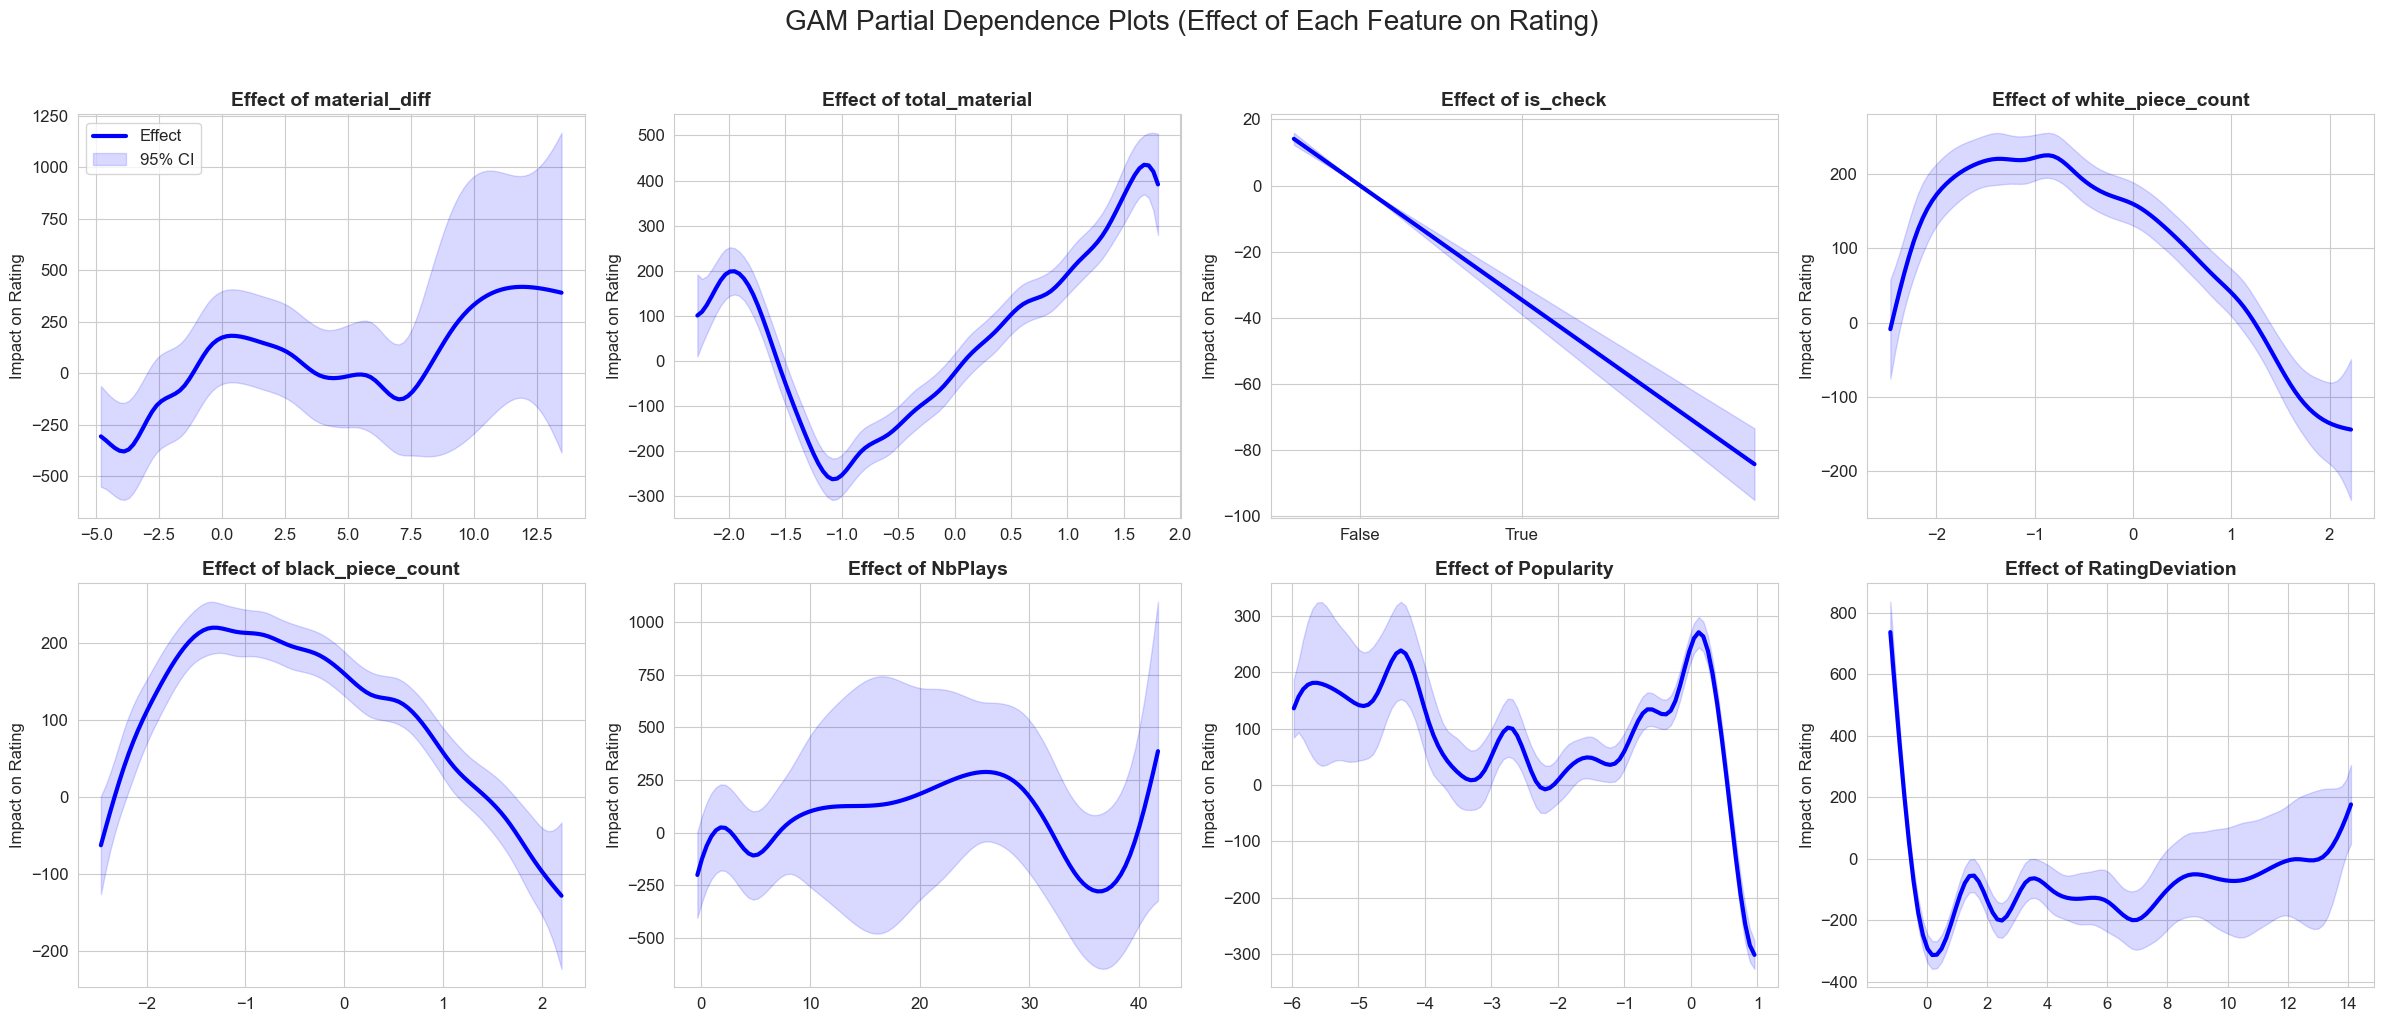

In [8]:
# --- 3.1 Fit GAM ---
print("Fitting GAM...")
# Define terms: s() for continuous, l() for binary 'is_check' (index 2)
gam_terms = s(0) + s(1) + l(2) + s(3) + s(4) + s(5) + s(6) + s(7)

# Fit model on the full scaled dataset
gam = LinearGAM(gam_terms).fit(X_scaled, y_num)

# Evaluate R-squared
print(f"GAM Pseudo R-Squared: {gam.statistics_['pseudo_r2']['explained_deviance']:.4f}")


# --- 3.2 FDR Correction ---
print("\n--- Statistical Significance (FDR Corrected) ---")

# Extract p-values (indices 1-8 correspond to the 8 terms)
p_values = [gam.statistics_['p_values'][i] for i in range(1, len(numerical_features) + 1)]

# Apply Benjamini-Hochberg correction
rejected, p_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

# Display Results Table
fdr_results = pd.DataFrame({
    'Feature': numerical_features,
    'Original P-Value': [f"{p:.2e}" for p in p_values],
    'Corrected P-Value': [f"{p:.2e}" for p in p_corrected],
    'Significant?': rejected
})
print(fdr_results)


# --- 3.3 Visualization GAM Partial Dependence for all Features ---
print("\nPlotting GAM Partial Dependence...")

# Setup the grid: 2 rows, 4 columns
fig, axs = plt.subplots(2, 4, figsize=(24, 10))
axs = axs.ravel()

for i, feature_name in enumerate(numerical_features):
    # Generate X grid for plotting
    XX = gam.generate_X_grid(term=i)
    
    # Get prediction (pdep) and confidence intervals (confi)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    
    # Plot the main effect line
    axs[i].plot(XX[:, i], pdep, c='blue', lw=3, label='Effect')
    
    # Plot the confidence intervals
    axs[i].fill_between(XX[:, i], confi[:, 0], confi[:, 1], color='blue', alpha=0.15, label='95% CI')
    
    # Styling
    axs[i].set_title(f"Effect of {feature_name}", fontsize=14, fontweight='bold')
    axs[i].set_ylabel("Impact on Rating")
    
    # Special handling for 'is_check' to show 0 and 1 clearly
    if feature_name == 'is_check':
        axs[i].set_xticks([0, 1])
        axs[i].set_xticklabels(['False', 'True'])
    
    if i == 0: 
        axs[i].legend()

plt.suptitle("GAM Partial Dependence Plots (Effect of Each Feature on Rating)", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

## **Observation:**
#### Besides, `Is Check`, The partial dependence plots reveal significant non-linearity, particularly in `Total Material` and `NbPlays`.

## 4. Predictive Accuracy (Tree-Based Models)
 
### **Methodology:**
#### Comparing **Random Forest** (Bagging) and **Gradient Boosting** (Boosting) regressors.
#### Feature importance is analyzed to determine the primary drivers of difficulty.


Training Tree Models...
Random Forest R²: 0.9067
Gradient Boosting R²: 0.3162


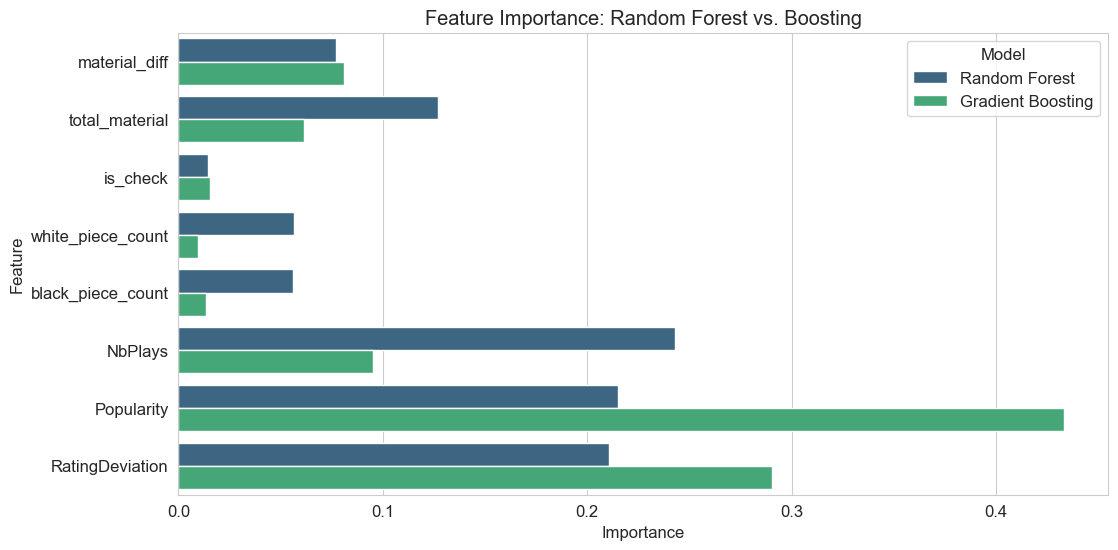

In [9]:

# --- 4.1 Train Models ---
print("Training Tree Models...")
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1).fit(X_scaled, y_num)
gb_reg = GradientBoostingRegressor(n_estimators=100, random_state=42).fit(X_scaled, y_num)

print(f"Random Forest R²: {rf_reg.score(X_scaled, y_num):.4f}")
print(f"Gradient Boosting R²: {gb_reg.score(X_scaled, y_num):.4f}")

# --- 4.2 Feature Importance Plot ---
fi_df = pd.DataFrame({
    'Feature': numerical_features,
    'Random Forest': rf_reg.feature_importances_,
    'Gradient Boosting': gb_reg.feature_importances_
}).melt(id_vars='Feature', var_name='Model', value_name='Importance')

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', hue='Model', data=fi_df, palette='viridis')
plt.title('Feature Importance: Random Forest vs. Boosting')
plt.show()


## **Observation:**
#### The Random Forest model achieved an exceptionally high $R^2$ of 0.9067, significantly outperforming the Gradient Boosting model ($R^2 \approx 0.32$). This large discrepancy suggests the Random Forest may be overfitting the training data, capturing noise as signal, whereas the Gradient Boosting model's performance is likely a more realistic estimate of generalizable predictive power on new data.


## 5. Classification (SVM vs. Random Forest vs. Boosting)
#
### **Methodology:**
#### Comparing a **Random Forest Classifier** and **Gradient Boosting** against a **Support Vector Machine (SVM)** with a non-linear **Radial Basis Function (RBF) kernel**.
 

Training Classifiers...


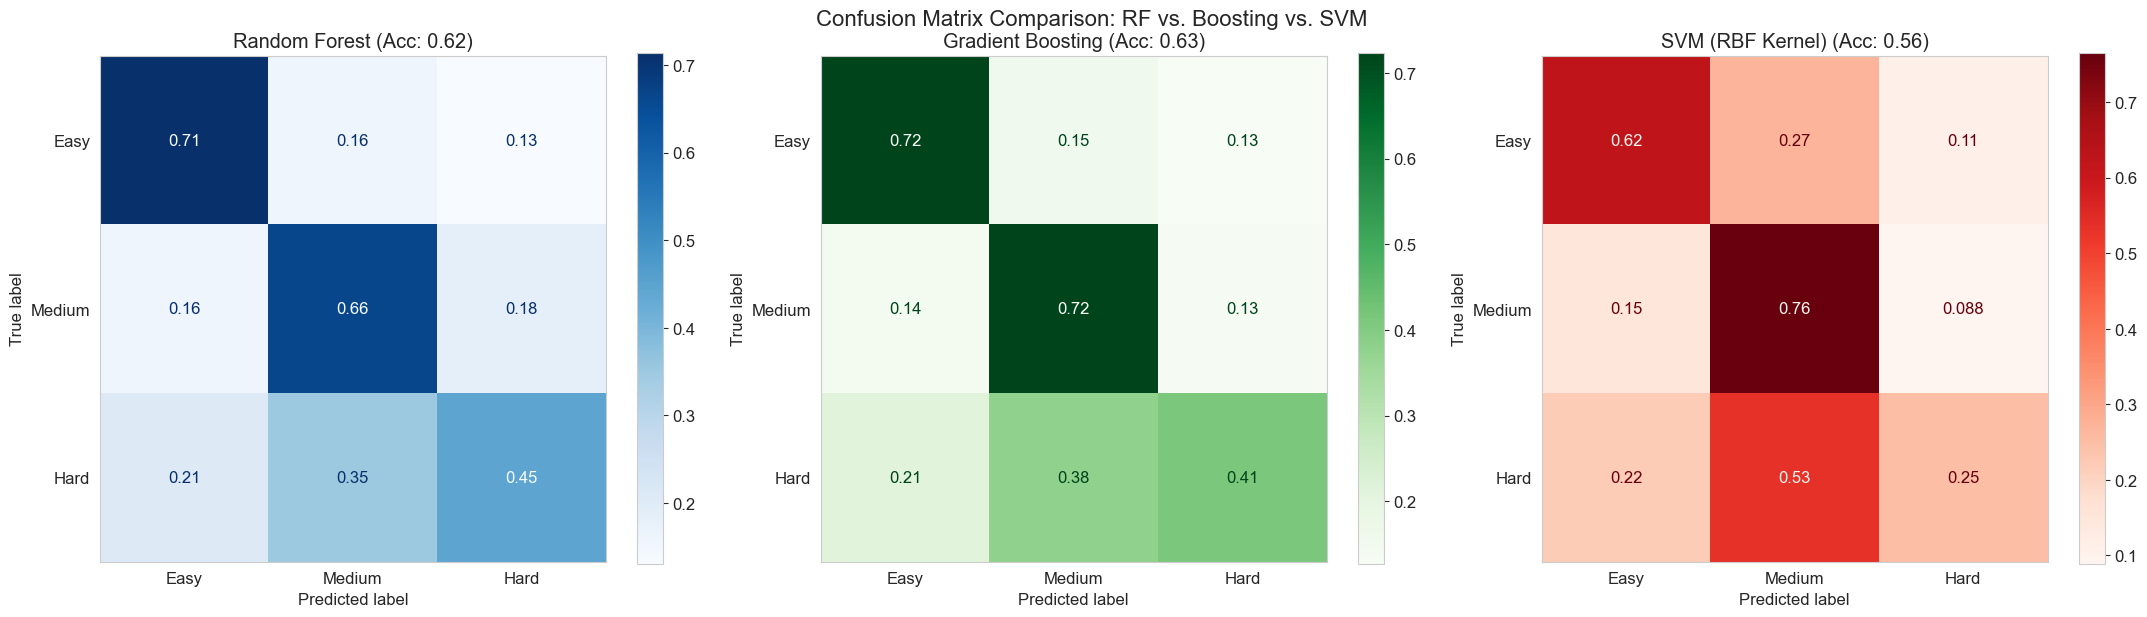

Interpretation:
- Diagonal elements (darker is better) represent correct predictions.
- Compare RF (Blues) vs Boosting (Greens) to see which tree method handles 'Hard' puzzles better.
- SVM (Reds) serves as a non-tree baseline.


In [10]:
# --- 5.1 Split & Train ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_cat, test_size=0.3, random_state=42)

# Subsample for SVM speed (it's slow on 35k rows)
X_train_sub, y_train_sub = X_train[:5000], y_train[:5000]

print("Training Classifiers...")
# 1. Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1).fit(X_train, y_train)
# 2. Gradient Boosting
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42).fit(X_train, y_train)
# 3. SVM (RBF)
svm_clf = SVC(kernel='rbf', C=1.0).fit(X_train_sub, y_train_sub)

# --- 5.2 Confusion Matrices (Side-by-Side) ---
fig, axes = plt.subplots(1, 3, figsize=(22, 6))
labels_order = ['Easy', 'Medium', 'Hard']

# Plot Random Forest
ConfusionMatrixDisplay.from_estimator(rf_clf, X_test, y_test, labels=labels_order, cmap='Blues', normalize='true', ax=axes[0])
axes[0].set_title(f'Random Forest (Acc: {rf_clf.score(X_test, y_test):.2f})')
axes[0].grid(False)

# Plot Gradient Boosting
ConfusionMatrixDisplay.from_estimator(gb_clf, X_test, y_test, labels=labels_order, cmap='Greens', normalize='true', ax=axes[1])
axes[1].set_title(f'Gradient Boosting (Acc: {gb_clf.score(X_test, y_test):.2f})')
axes[1].grid(False)

# Plot SVM
ConfusionMatrixDisplay.from_estimator(svm_clf, X_test, y_test, labels=labels_order, cmap='Reds', normalize='true', ax=axes[2])
axes[2].set_title(f'SVM (RBF Kernel) (Acc: {svm_clf.score(X_test, y_test):.2f})')
axes[2].grid(False)

plt.suptitle("Confusion Matrix Comparison: RF vs. Boosting vs. SVM", fontsize=16)
plt.tight_layout()
plt.show()

print("Interpretation:")
print("- Diagonal elements (darker is better) represent correct predictions.")
print("- Compare RF (Blues) vs Boosting (Greens) to see which tree method handles 'Hard' puzzles better.")
print("- SVM (Reds) serves as a non-tree baseline.")

## **Observation:**
#### The Confusion Matrices reveal that tree-based methods (RF and Boosting) generally outperform the SVM.
#### All models struggle most with the "Hard" category, often misclassifying it as "Medium".

## 6. Unsupervised Learning (Clustering)

### **Methodology:**
#### Applying **K-Means Clustering** to discover latent puzzle types.
#### **Hierarchical Clustering** (Dendrogram) is used to visualize the structure of these groups.
#### **PCA** is applied to visualize the clusters in 2D space.

Running K-Means...

K-Means Cluster Summary:
         total_material  is_check       Rating      NbPlays
Cluster                                                    
0             58.024303  0.001780  1520.749514  1971.364924
1             25.492291  0.000354  1487.083348  1505.390336
2             45.039428  0.119763  1449.382454    24.033514
3             43.131659  1.000000  1333.047902  1505.598636

Generating Dendrogram...


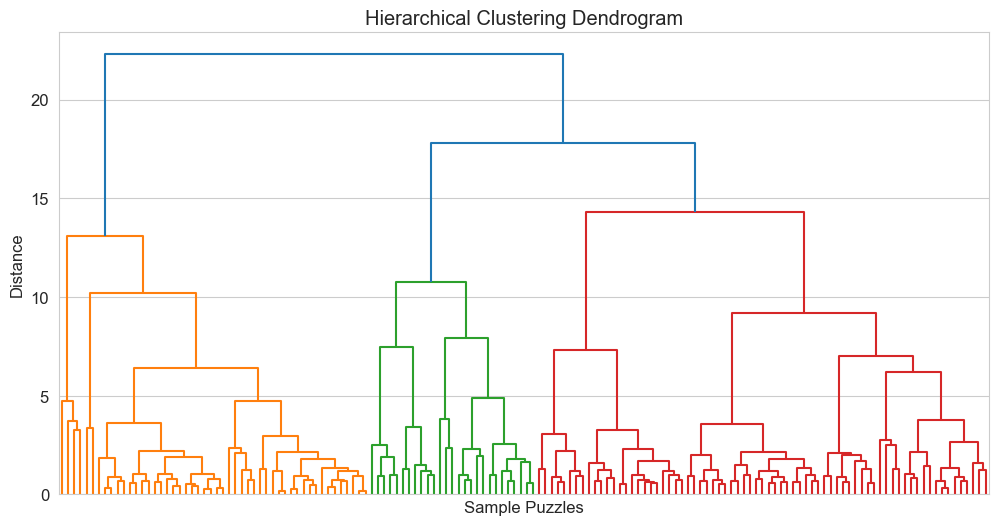

Generating 2D Cluster Visualization using PCA...


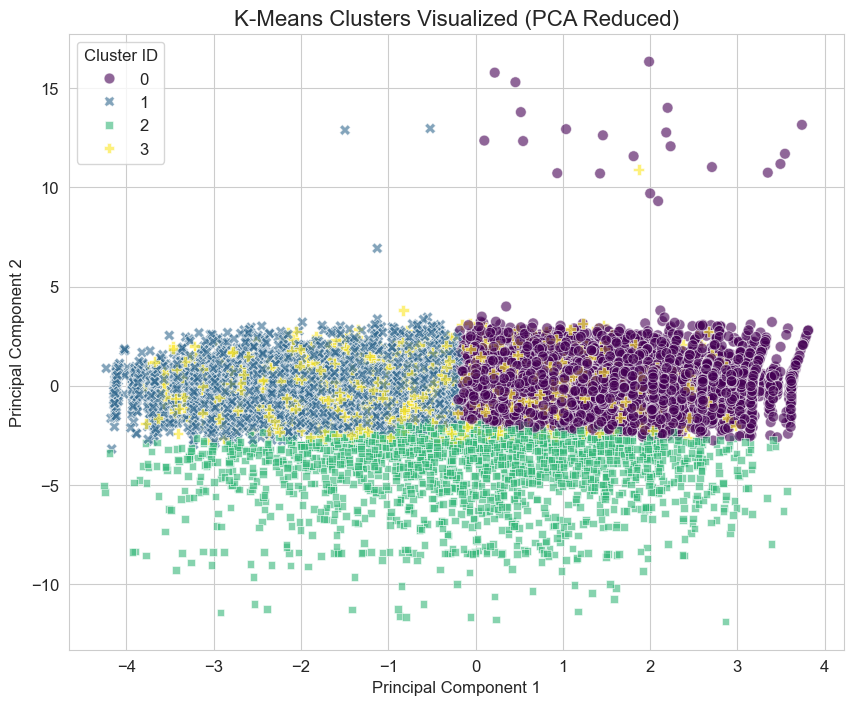

Interpretation: Each color represents a cluster. Distinct blobs indicate good separation.


In [ ]:
# --- 6.1 K-Means --- 
# K = 4 determined by elbow method.
print("Running K-Means...")
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10).fit(X_scaled)
df['Cluster'] = kmeans.labels_

# Cluster Summary Table
cluster_summary = df.groupby('Cluster')[['total_material', 'is_check', 'Rating', 'NbPlays']].mean()
print("\nK-Means Cluster Summary:")
print(cluster_summary)

# --- 6.2 Dendrogram ---
print("\nGenerating Dendrogram...")
X_sample_dendro = X_scaled[:150]
linked = linkage(X_sample_dendro, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked, orientation='top', show_leaf_counts=True, no_labels=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Puzzles')
plt.ylabel('Distance')
plt.show()

# --- 6.3 Visualization: 2D Cluster Scatter Plot (PCA) ---
from sklearn.decomposition import PCA

print("Generating 2D Cluster Visualization using PCA...")

# 1. Reduce to 2 Dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 2. Create a DataFrame for plotting
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Cluster'] = df['Cluster']

# 3. Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_pca, x='PC1', y='PC2', 
    hue='Cluster', palette='viridis', 
    style='Cluster', alpha=0.6, s=60
)
plt.title('K-Means Clusters Visualized (PCA Reduced)', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster ID')
plt.show()

## **Observation:**
#### The clusters align with chess concepts:
#### Cluster 3 ("Forced Tactics"):

#### Evidence: is_check = 1.000 (100%).

#### Rating: 1333 (Lowest difficulty).

#### Interpretation: Puzzles starting with a check are the easiest because the opponent's response is forced, limiting calculation depth.

#### Cluster 1 ("Endgames"):

#### Evidence: total_material = 25.5 (Lowest).

#### Rating: 1487.

#### Interpretation: Low material signifies endgames. These are harder than forced tactics but slightly easier than complex middlegames.

#### Cluster 0 ("Complex Middlegames"):

#### Evidence: total_material = 58.0 (Highest).

#### Rating: 1521 (Highest difficulty).

#### Interpretation: High material counts signify middlegames with many pieces, leading to the highest complexity and difficulty.

#### Cluster 2 ("The Unknowns"):

#### Evidence: NbPlays = 24 (Extremely low compared to ~1500-1900 for others).

#### Interpretation: This cluster grouped puzzles not by board state, but by lack of history. These are likely new puzzles with unstable ratings.